# Logistic Regression

    Ethan Crawford

    Math 437

    12/4/23

In [1]:
import numpy as np
from scipy.optimize import minimize
from sklearn.linear_model import LogisticRegression
from sklearn import datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn import svm
import pandas as pd
import statsmodels.api as sm
import time
from matplotlib import pyplot as plt

## Problem 1

Create a classifier called `LogiReg` that accepts an $(n \times 1)$ array $y$ of binary labels ($0$'s and $1$'s) as well as an $(n \times d)$ array $X$ of data points. Write a `fit()` method that finds and saves the optimal $\widehat{\boldsymbol{\beta}}$.

## Problem 2

Write a method called `predict_prob()` that accepts an $(n \times d)$ array $x\_test$ and returns $P(Y=1 | x\_test)$. Also write a method called `predict()` that calls `predict_prob()` and returns an array of predicted labels ($0$'s or $1$'s) for the given array $x\_test$.

In [2]:
class LogiReg(): 
    
    def fit(self, X, y):
        """
        input:
        X: ndarray(n, d)
        y: ndarray(n, 1) taking values only in {0,1}
        
        Save y and X as attributes.
        Updates beta, the coefficient array of shape (d, 1) that
        minimizes the negative log likelihood for the given data 
        with the model p(y|x) = sigm(x^T @ beta).      
        """
        # Save X and y as attributes
        self.X = X
        self.y = y

        # Fill in the values according to 13.2
        def NLL(beta):
            return np.sum(y*np.log(1 + np.exp(-X @ beta)) + (1-y)*np.log(1 + np.exp(X @ beta)))
        
        # Minimize the negative log likelihood and save the coefficients
        self.beta = minimize(NLL, np.ones((X.shape[1], 1))).x
                
    def predict_prob(self, x_test):
        """
        Returns the predicted probability of an input x_test.
        If x_test has shape (p, q), then the predicted probability
        has shape (1, q).
        """ 
        return 1/(1 + np.exp(-x_test @ self.beta))
        
        
    def predict(self, x_test):
        """
        Returns the predicted classification (1 or 0) of x_test.
        If x_test has shape (p, q), then the predicted classification
        has shape (1, q).
        """      
        # Get the predicted probabilities
        pred = self.predict_prob(x_test)
        
        # Return 1 if the probability is greater than 0.5, 0 otherwise
        return np.where(pred > 0.5, 1, 0)

## Problem 3

Test your classifier from the previous two problems using arrays $X$, $y$, and $X\_test$. Train your classifier on $X$ and $y$. Then generate a list of predicted labels using your trained classifier and $X\_test$, and use it to plot $X\_test$ with a different color for each predicted label.

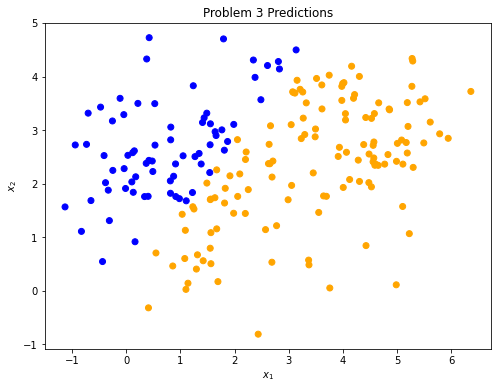

In [29]:
data = np.column_stack(( 
    np.concatenate(( 
        # draw from 2 2-dim. multivariate normal dists.
        np.random.multivariate_normal(np.array([1,2]), np.eye(2), 100),
        np.random.multivariate_normal(np.array([4,3]), np.eye(2), 100) )), 
    # labels corresonding to each distribution
    np.concatenate(( np.zeros(100), np.ones(100) )) ))
np.random.shuffle(data)
# extract X and y from the shuffled data
X = data[:,:2]
y = data[:,2].astype(int)

X_test = np.concatenate(( 
    # draw from 2 identical 2-dim. multivariate normal dists.
    np.random.multivariate_normal(np.array([1,2]), np.eye(2), 100),
    np.random.multivariate_normal(np.array([4,3]), np.eye(2), 100) ))
np.random.shuffle(X_test)

# Instance and fit the model
model = LogiReg()
model.fit(X, y)
pred = model.predict(X_test)

# Plot
plt.figure(figsize=(8,6))
plt.scatter(X_test[:,0], X_test[:,1], c=['blue' if p == 0 else 'orange' for p in pred])
plt.title('Problem 3 Predictions')
plt.xlabel('$x_1$')
plt.ylabel('$x_2$')
plt.show()

## Problem 4

Using each of `LogiReg`, `statsmodels.Logit`, `sklearn.LogisticRegression`, and `sklearn.svm` train a logistic regression classifier on $X$ and $y$ to generate a list of predicted labels for $X\_test$. Then, using $y\_test$, print the accuracy scores for each trained model. Compare the accuracies and training/testing time for all three classifiers. Be sure to add a constant feature with each model.

In [21]:
# predefine the true beta
beta = np.random.normal(0, 7, 20)

# X is generated from 2 20-dim. multivariate normal dists.
X = np.concatenate(( 
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20)*2, np.eye(20), 100) ))
np.random.shuffle(X)
# create y based on the true beta
pred = 1. / (1. + np.exp(-X @ beta))  
y = np.array( [1 if pred[i] >= 1/2 else 0 
            for i in range(pred.shape[0])] )

# X_test and y_test are generated similar to X and y
X_test = np.concatenate(( 
        np.random.multivariate_normal(np.zeros(20), np.eye(20), 100), 
        np.random.multivariate_normal(np.ones(20), np.eye(20), 100) ))
np.random.shuffle(X_test)
pred = 1. / (1. + np.exp(-X_test @ beta))
y_test = np.array( [1 if pred[i] >= 1/2 else 0 
            for i in range(pred.shape[0])] )

###########
# LogiReg #
###########
model = LogiReg()

time_start = time.time()
model.fit(X, y)
print('LogiReg training time:', time.time() - time_start)

time_start = time.time()
pred = model.predict(X_test)
print('LogiReg prediction time:', time.time() - time_start)

print('LogiReg accuracy:', accuracy_score(y_test, pred), '\n')

#####################
# statsmodels.Logit #
####################
time_start = time.time()
model = sm.Logit(y, X).fit_regularized(disp=0)
print('statsmodels.Logit training time:', time.time() - time_start)

time_start = time.time()
pred = model.predict(X_test)
print('statsmodels.Logit prediction time:', time.time() - time_start)

print('statsmodels.Logit accuracy:', accuracy_score(y_test, np.where(pred > 0.5, 1, 0)), '\n')

##############################
# sklearn.LogisticRegression #
##############################
model = LogisticRegression()

time_start = time.time()
model.fit(X, y)
print('sklearn.LogisticRegression training time:', time.time() - time_start)

time_start = time.time()
pred = model.predict(X_test)
print('sklearn.LogisticRegression prediction time:', time.time() - time_start)

print('sklearn.LogisticRegression accuracy:', accuracy_score(y_test, pred), '\n')

###############
# sklearn.svm #
###############
model = svm.SVC(kernel='linear')

time_start = time.time()
model.fit(X, y)
print('sklearn.svm training time:', time.time() - time_start)

time_start = time.time()
pred = model.predict(X_test)
print('sklearn.svm prediction time:', time.time() - time_start)

print('sklearn.svm accuracy:', accuracy_score(y_test, pred), '\n')

LogiReg training time: 0.09761404991149902
LogiReg prediction time: 0.0003268718719482422
LogiReg accuracy: 0.93 

statsmodels.Logit training time: 0.0623476505279541
statsmodels.Logit prediction time: 0.00021791458129882812
statsmodels.Logit accuracy: 0.93 

sklearn.LogisticRegression training time: 0.008820056915283203
sklearn.LogisticRegression prediction time: 0.0006122589111328125
sklearn.LogisticRegression accuracy: 0.935 

sklearn.svm training time: 0.0039048194885253906
sklearn.svm prediction time: 0.0007987022399902344
sklearn.svm accuracy: 0.96 



/home/ethancrawford/.local/lib/python3.10/site-packages/statsmodels/discrete/discrete_model.py:2383: RuntimeWarning: overflow encountered in exp
  return 1/(1+np.exp(-X))


## Problem 5

Import the Iris Dataset and perform a train-test split on only the first two columns of the data with `test_size=0.4`. Train a multinomial logistic regression model using the training data with an added constant feature, and generate prediction labels for the test data.

Plot the test data by color using your prediction labels. Also, print the model score

sklearn.LogisticRegression accuracy: 0.7333333333333333 



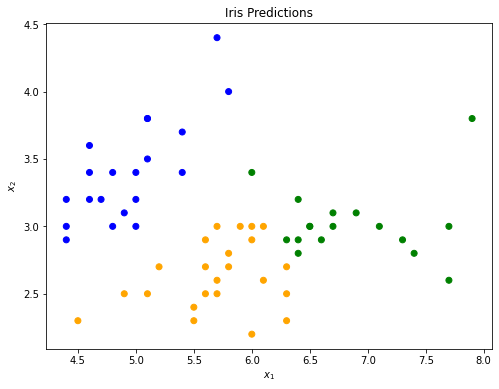

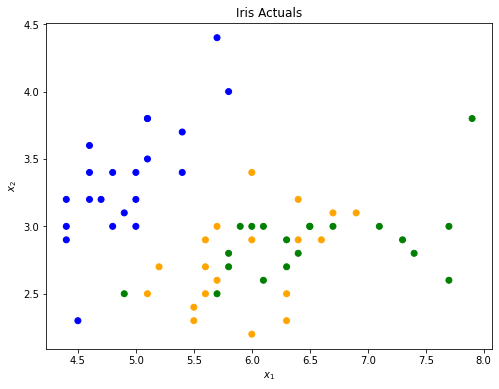

In [28]:
# Load the iris dataset
iris = datasets.load_iris()

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(iris.data, iris.target, test_size=0.4)

# Select only the first two features
X_train = X_train[:,:2]
X_test = X_test[:,:2]

# Instance and fit the model
model = LogisticRegression(multi_class='multinomial', fit_intercept=True).fit(X_train, y_train)

# Predict the classes of the testing data
pred = model.predict(X_test)

# Print the model score
print('sklearn.LogisticRegression accuracy:', accuracy_score(y_test, pred), '\n')

# Plot predictions
for data, title in zip([pred, y_test], ['Predictions', 'Actuals']):
    plt.figure(figsize=(8,6))
    plt.scatter(X_test[:,0], X_test[:,1], c=['blue' if p == 0 else 'orange' if p == 1 else 'green' for p in data])
    plt.title(f'Iris {title}')
    plt.xlabel('$x_1$')
    plt.ylabel('$x_2$')
    plt.show()